In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

Data Preprocessing

In [69]:
df = pd.read_csv("Data-Historis-BMRI-Monthly.csv")
df.head()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,01/10/2025,4.79,4.36,4.83,4.01,"4,11B","8,86%"
1,01/09/2025,4.40,4.55,4.75,4.31,"3,89B","-6,98%"
2,01/08/2025,4.73,4.57,4.98,4.51,"2,97B","4,88%"
3,01/07/2025,4.51,4.90,4.99,4.51,"3,87B","-7,58%"
4,01/06/2025,4.88,5.20,5.30,4.80,"2,50B","-7,92%"


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tanggal     36 non-null     object 
 1   Terakhir    36 non-null     float64
 2   Pembukaan   36 non-null     float64
 3   Tertinggi   36 non-null     float64
 4   Terendah    36 non-null     float64
 5   Vol.        36 non-null     object 
 6   Perubahan%  36 non-null     object 
dtypes: float64(4), object(3)
memory usage: 2.1+ KB


In [71]:
# clean volume colume ( delete B)
df['Vol.'] = df['Vol.'].str.replace('B', '', regex=False)
df['Vol.'] = df['Vol.'].str.replace('.', '', regex=False)
df['Vol.'] = df['Vol.'].str.replace(',', '.', regex=False)
df['Vol.'] = df['Vol.'].astype(float)

# clean changable volume% (hapus '%' dan ubah ke float)
df['Perubahan%'] = df['Perubahan%'].str.replace('%', '', regex=False)
df['Perubahan%'] = df['Perubahan%'].str.replace(',', '.', regex=False)
df['Perubahan%'] = df['Perubahan%'].astype(float)

# change date column
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y', errors='coerce', dayfirst=True)

df = df.dropna(subset=['Tanggal'])
df = df.sort_values('Tanggal').reset_index(drop=True)
df = df.set_index('Tanggal')

print(df.dtypes)
print(df.head())

Terakhir      float64
Pembukaan     float64
Tertinggi     float64
Terendah      float64
Vol.          float64
Perubahan%    float64
dtype: object
            Terakhir  Pembukaan  Tertinggi  Terendah  Vol.  Perubahan%
Tanggal                                                               
2022-11-01     5.263      5.300      5.400     4.925  1.97       -0.24
2022-12-01     4.963      5.263      5.500     4.888  2.66       -5.70
2023-01-01     4.975      4.963      5.075     4.450  2.12        0.25
2023-02-01     5.000      4.975      5.275     4.788  1.72        0.50
2023-03-01     5.163      5.075      5.475     4.913  2.42        3.25


In [72]:
print("First date in data:", df.index[0])
print("Last date in data:", df.index[-1])

First date in data: 2022-11-01 00:00:00
Last date in data: 2025-10-01 00:00:00


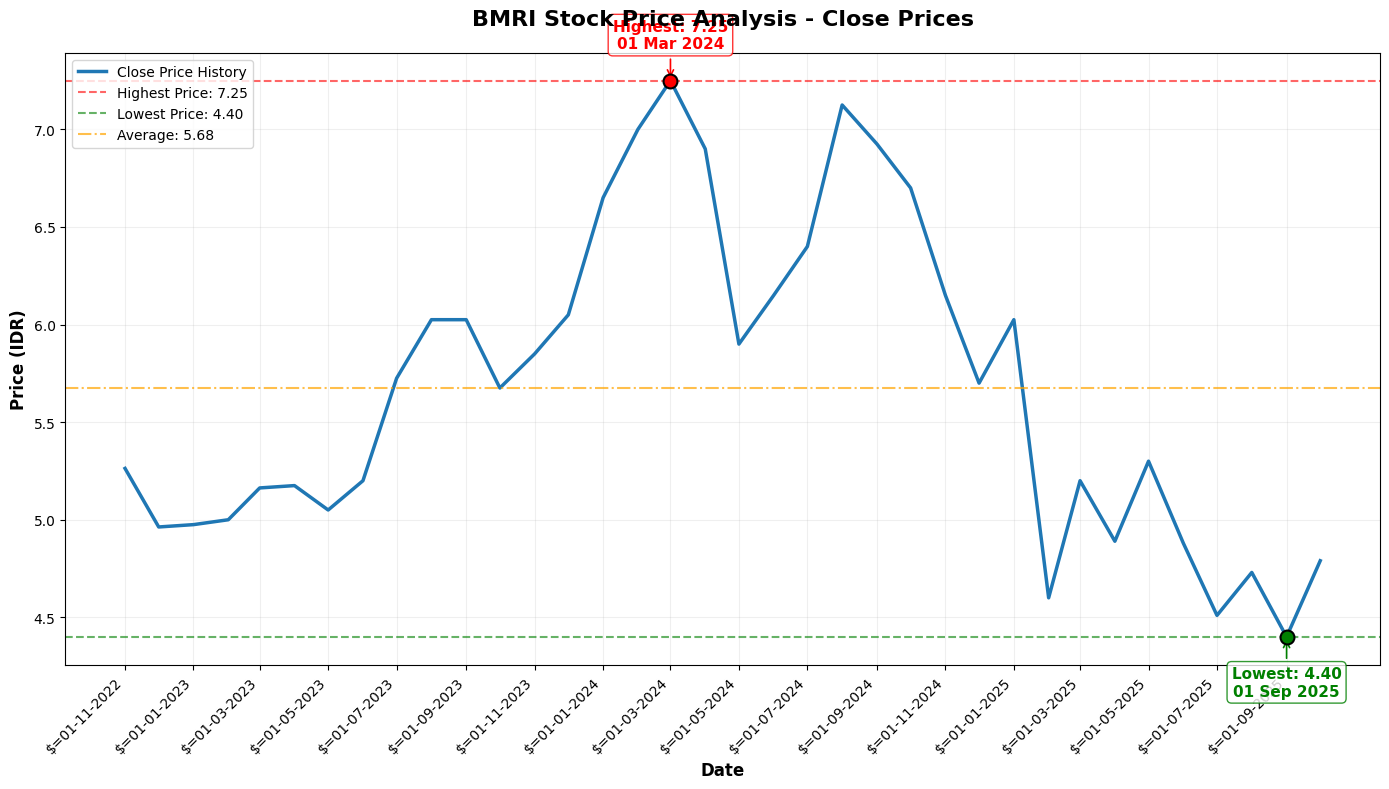

In [73]:
# Close price visualitation

plt.figure(figsize=(14, 8))

plt.plot(df.index, df['Terakhir'], label='Close Price History', color='#1f77b4', linewidth=2.5)

# calculate highest and lowest prices
max_price = df['Terakhir'].max()
min_price = df['Terakhir'].min()
max_price_idx = df['Terakhir'].idxmax()
min_price_idx = df['Terakhir'].idxmin()

# get the corresponding dates
max_date = max_price_idx
min_date = min_price_idx

# Highlight the highest price point
plt.scatter(max_price_idx, max_price, color='red', s=100,
      zorder=5, edgecolors='black', linewidth=1.5)
plt.annotate(f'Highest: {max_price:.2f}\n{max_date.strftime("%d %b %Y")}',
      xy =(max_price_idx, max_price),
      xytext=(max_price_idx, max_price + 0.15),
      fontsize=11, color='red', fontweight='bold',
      ha='center', va='bottom',
      bbox=dict(boxstyle='round,pad=0.3', facecolor=
      'white', alpha=0.8, edgecolor='red'),
      arrowprops=dict(arrowstyle='->', color='red',
      lw=1.2))

# Highlight the lowest price point
plt.scatter(min_price_idx, min_price, color='green', s=100,
      zorder=5, edgecolors='black', linewidth=1.5)
plt.annotate(f'Lowest: {min_price:.2f}\n{min_date.strftime("%d %b %Y")}',
      xy=(min_price_idx, min_price),
      xytext=(min_price_idx, min_price - 0.15),
      fontsize=11, color='green', fontweight='bold',
       ha='center', va='top',
       bbox=dict(boxstyle='round,pad=0.3', facecolor=
      'white', alpha=0.8, edgecolor='green'),
      arrowprops=dict(arrowstyle='->', color='green',
      lw=1.2))

# Add horizontal lines for min and max prices
plt.axhline(max_price, linestyle='--', color='red', alpha=
      0.6, label=f'Highest Price: {max_price:.2f}')
plt.axhline(min_price, linestyle='--', color='green', alpha=
      0.6, label=f'Lowest Price: {min_price:.2f}')

# Calculate and display the average price
avg_price = df['Terakhir'].mean()
plt.axhline(avg_price, linestyle='-.', color='orange',
      alpha=0.7, label=f'Average: {avg_price:.2f}')

# Style the chart
plt.title('BMRI Stock Price Analysis - Close Prices',
      fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Price (IDR)', fontsize=12, fontweight='bold')

# Format x-axis with dates
date_labels = [i.strftime('$=%d-%m-%Y') for i in df.index]
plt.xticks(df.index[::2], date_labels[::2], rotation=45, ha=
      'right', fontsize=10)

plt.grid(True, linestyle='-', alpha=0.2)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

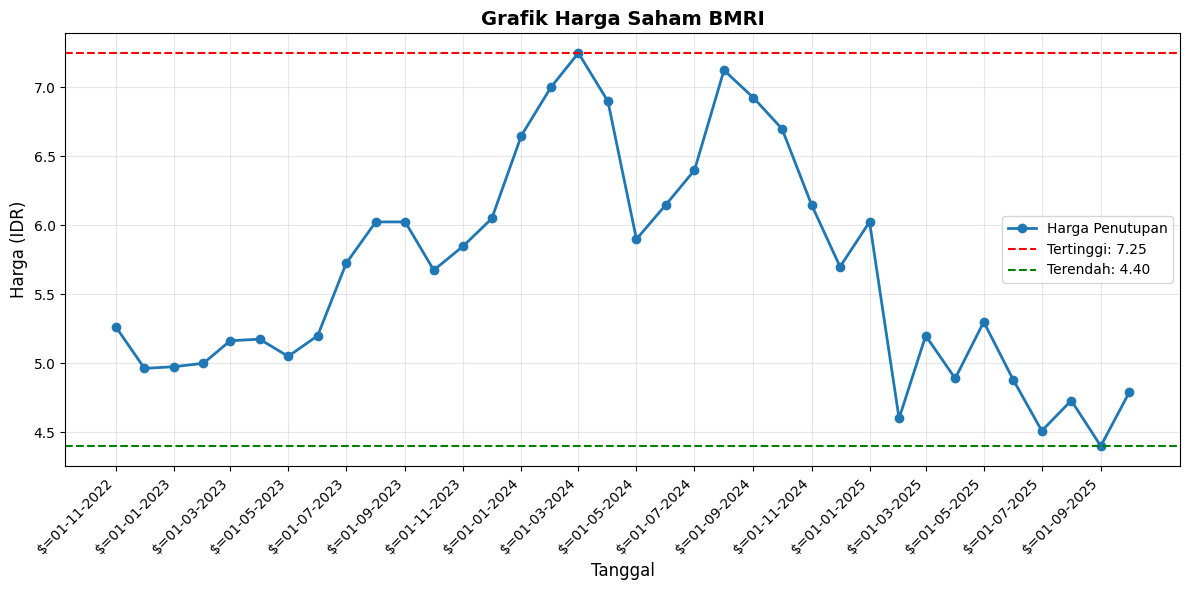

In [74]:
# short Visualisasi harga penutupan saham
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Terakhir'], marker='o', linewidth=2,
      markersize=6, label='Harga Penutupan')
 
# Tambahkan garis harga tertinggi dan terendah
plt.axhline(y=df['Terakhir'].max(), color='red', linestyle=
      '--', label=f'Tertinggi: {df["Terakhir"].max():.2f}')
plt.axhline(y=df['Terakhir'].min(), color='green',
      linestyle='--', label=f'Terendah: {df["Terakhir"].min():.2f}')

# Format grafik
plt.title('Grafik Harga Saham BMRI', fontsize=14,
      fontweight='bold')
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga (IDR)', fontsize=12)
plt.xticks(df.index[::2], date_labels[::2], rotation=45, ha=
      'right', fontsize=10)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Feature Engineering

In [75]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Terakhir'].values.reshape(-1, 1))

In [76]:
def create_sequences(data, sequence_length):
    X , y =[], []
    if len(data) <= sequence_length:
        print(f"data is too short (len={len(data)}) for sequence_length={sequence_length}")
        return np.array([]), np.array([])
    
    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [77]:
sequence_length = 1

# create all dataframe sequences
X, y = create_sequences(scaled_data, sequence_length)

# reshape to (samples, timestamps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# split data
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [78]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


X_train: (28, 1, 1)
y_train: (28,)
X_test: (7, 1, 1)
y_test: (7,)


In [79]:
print("scaled_data.shape =", scaled_data.shape)
print("train_size =", int(len(scaled_data) * 0.8))
print("sequence_length =", sequence_length)
print("len(train_data) =", len(scaled_data[:int(len(scaled_data) * 0.8)]))


scaled_data.shape = (36, 1)
train_size = 28
sequence_length = 1
len(train_data) = 28


In [80]:

print("type(X_train) =", type(X_train))
print("X_train.shape raw =", getattr(X_train, "shape", None))
print("X_train.ndim =", getattr(X_train, "ndim", None))
print("X_train.size =", getattr(X_train, "size", None))
print("sample X_train[0] =", X_train[0] if X_train.size>0 else "EMPTY")

type(X_train) = <class 'numpy.ndarray'>
X_train.shape raw = (28, 1, 1)
X_train.ndim = 3
X_train.size = 28
sample X_train[0] = [[0.30280702]]


In [81]:
print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

X_train.shape = (28, 1, 1)
y_train.shape = (28,)
X_test.shape = (7, 1, 1)
y_test.shape = (7,)


Model Building

In [82]:
model = Sequential()

n_timesteps = X_train.shape[1]   # sequence_length
n_features  = X_train.shape[2] 

# First layer LSTM
model.add(Input(shape=(n_timesteps, n_features)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# second layer LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense Layer
model.add(Dense(units=25))
model.add(Dense(units=1))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=8,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 604ms/step - loss: 0.3602 - val_loss: 0.2422
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3206 - val_loss: 0.2106
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2806 - val_loss: 0.1807
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2492 - val_loss: 0.1520
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2129 - val_loss: 0.1250
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1821 - val_loss: 0.1000
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1436 - val_loss: 0.0780
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1173 - val_loss: 0.0604
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0778 - val_loss: 0.0491
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0631 - val_loss: 0.0449
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0510 - val_loss: 0.0493
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0496 - val_loss: 0.0606


Model Evaluation

In [84]:
from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# y_test_scaled for inverse transforming y_test
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_scaled, predictions)
print(f"Mean squared error: {mse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Mean squared error: 0.2959319971048488


In [85]:
len(predictions)

7

Preidction Future IHSG Price in 1 Month

In [86]:
future_days = 30

last_30_days = df['Terakhir'].values[-sequence_length:].reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)

future_predictions = []

for _ in range(future_days):
    X_predict = np.array([last_30_days_scaled])
    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)
    future_predictions.append(predicted_price_unscaled[0, 0])

    # Update window
    last_30_days_scaled = np.append(last_30_days_scaled[1:], predicted_price, axis=0)
    last_30_days_scaled = last_30_days_scaled.reshape(-1, 1)

# input from appended values into futture_predictions
future_predictions = np.array(future_predictions)

# padding predictions for balance predictions
pad_length = len(df) - len(predictions)
pred_padded = np.concatenate((np.full((pad_length, 1), np.nan), predictions))

# ensure index is datetime
if not np.issubdtype(df.index.dtype, np.datetime64):
    df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True, errors='coerce')
    df = df.set_index('Tanggal')

# create dataframe prediction result for forecasting
last_date = df.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1), 
    periods=future_days, freq='D')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

Visualitation IHSG Prediction

/var/folders/s0/01h8dy1902zgb59dr1yqy6jr0000gn/T/ipykernel_80976/1100113078.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.annotate(f'{float(predictions[i]):.2f}',
/var/folders/s0/01h8dy1902zgb59dr1yqy6jr0000gn/T/ipykernel_80976/1100113078.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xy=(df.index[-len(predictions):][i], float(predictions[i])),


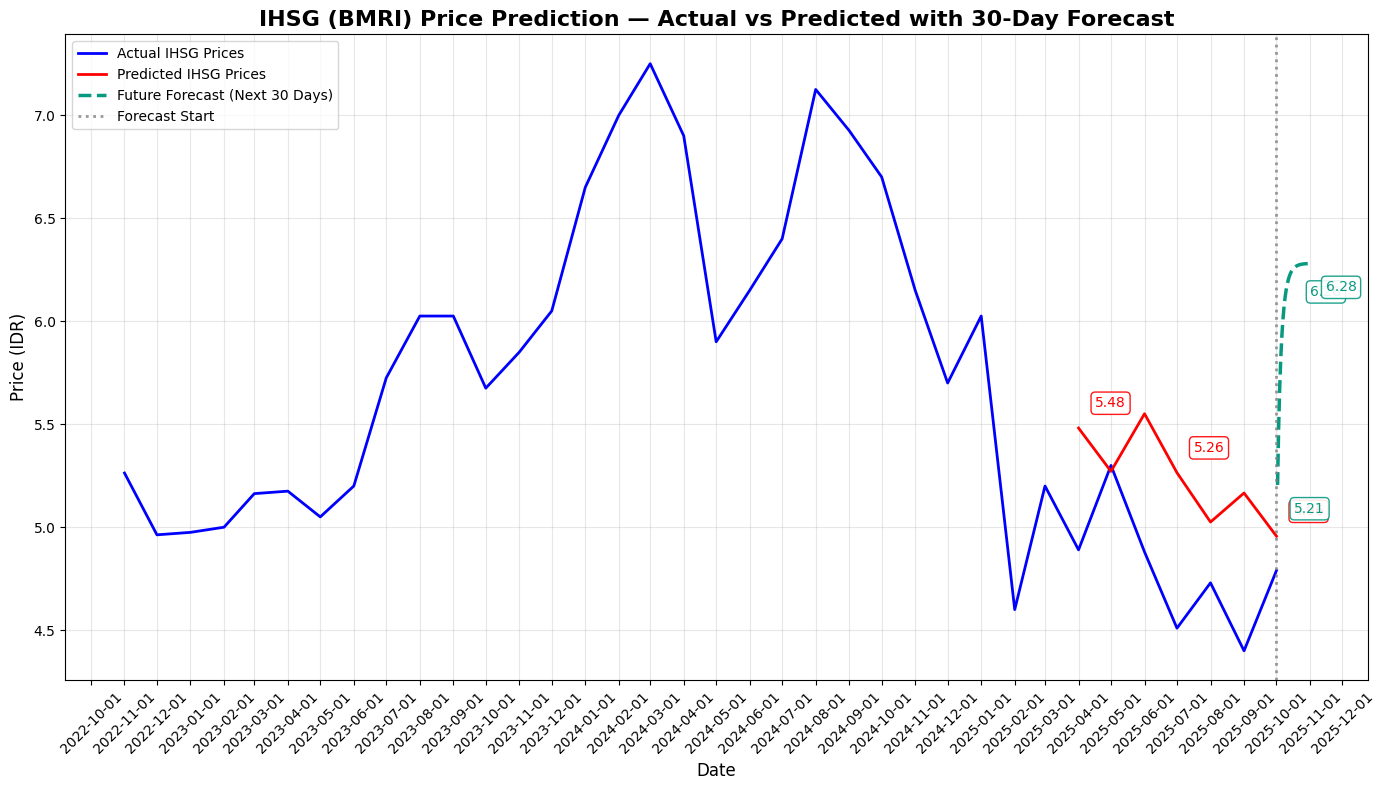

In [87]:
plt.figure(figsize=(14, 8))

# Blue: actual data
plt.plot(df.index, df['Terakhir'], label='Actual IHSG Prices', color='blue', linewidth=2)

# Red: model prediction aligned with test data
pred_line = plt.plot(df.index[-len(predictions):], predictions, label='Predicted IHSG Prices', color='red', linewidth=2.0)

# Add minimal annotations to red prediction line (first, middle, and last points only)
pred_indices = [0, len(predictions)//2, len(predictions)-1] if len(predictions) > 1 else [0]
for i in pred_indices:
    if i < len(df.index[-len(predictions):]) and i < len(predictions):
        plt.annotate(f'{float(predictions[i]):.2f}', 
                    xy=(df.index[-len(predictions):][i], float(predictions[i])),
                    xytext=(12, 15), textcoords='offset points',
                    color='red', fontsize=10, ha='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='red'))

# Green: forecast (next 30 days after last data)
forecast_line = plt.plot(future_dates, future_predictions, label='Future Forecast (Next 30 Days)',
         color='#089981', linestyle='--', linewidth=2.5)

# Add minimal annotations to green forecast line (first, middle, and last points only)
forecast_indices = [0, len(future_predictions)//2, len(future_predictions)-1] if len(future_predictions) > 1 else [0]
for i in forecast_indices:
    if i < len(future_dates) and i < len(future_predictions):
        plt.annotate(f'{float(future_predictions[i]):.2f}', 
                    xy=(future_dates[i], float(future_predictions[i])),
                    xytext=(12, -20), textcoords='offset points',
                    color='#089981', fontsize=10, ha='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='#089981'))

# Forecast start line
plt.axvline(x=last_date, color='gray', linestyle=':', linewidth=2, alpha=0.8, label='Forecast Start')

plt.title('IHSG (BMRI) Price Prediction — Actual vs Predicted with 30-Day Forecast',
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (IDR)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()


In [88]:
# ...existing code...
print("len(df)=", len(df))
print("len(predictions)=", len(predictions))
print("predictions.shape =", getattr(predictions, "shape", None))
print("predictions.dtype =", getattr(predictions, "dtype", None))
print("any NaN in predictions?", np.isnan(predictions).any())
print("any Inf in predictions?", np.isinf(predictions).any())
print("X_test.shape =", getattr(X_test, "shape", None))
# ...existing code...

len(df)= 36
len(predictions)= 7
predictions.shape = (7, 1)
predictions.dtype = float32
any NaN in predictions? False
any Inf in predictions? False
X_test.shape = (7, 1, 1)


In [89]:
# Transforming into DataFrame with pandas
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price IHSG': future_predictions
})

future_predictions_df.tail()

,Date,Predicted Price IHSG
25,2025-10-27,6.278456
26,2025-10-28,6.278903
27,2025-10-29,6.279254
28,2025-10-30,6.279530
29,2025-10-31,6.279747


In [90]:
# calculate percentage change from the last actual close price
last_actual_price = df['Terakhir'].iloc[-1]
percentage_change = ((future_predictions_df['Predicted Price IHSG'].iloc[-1] - last_actual_price) / last_actual_price) * 100

# Determine profit or loss
status = "profit" if percentage_change > 0 else "loss"

# print the percentage prediction
print(f"Percentage prediction for 30 days is: {status} {abs(percentage_change):.2f}%")

Percentage prediction for 30 days is: profit 31.10%
